<a href="https://colab.research.google.com/github/Kat-ies/Coursework/blob/faster_rcnn/face_detection/Face_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!git clone https://github.com/Kat-ies/Coursework.git
!git clone --single-branch --branch faster_rcnn https://github.com/Kat-ies/Coursework.git
%cd Coursework/src
%run for_google_drive.py

# Шаг 1.
Сделаем свой класс, который красиво склеит мои картинки и рамки из прошлой работы и подсунет их торчу в том виде, в котором ему надо (интернет сказал, что именно таким способом предобученным моделям подают свои датасеты).   
Вроде как в target  моим сеткам нужны только boxes и labels.


In [2]:
# file custom_dataset_class.py
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class MyDataset(Dataset):
    def __init__(self, train_dicts, transforms=None):
        self.images = train_dicts[0]
        self.frames = train_dicts[1]
        self.keys_list = list(train_dicts[0].keys())
        self.transforms = transforms

    def __getitem__(self, idx):
        dict_key = self.keys_list[idx]
        img = self.images[dict_key]

        boxes = []
        labels = np.ones(len(self.frames[dict_key]))

        for rects in self.frames[dict_key]:
            boxes.append([rects.x, rects.y, rects.x + rects.w, rects.y + rects.h])

        boxes = torch.as_tensor(boxes, dtype=torch.int64)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transforms is not None:
            # Note that target (including bbox) is also transformed\enhanced here,
            # which is different from transforms from torchvision import 
            # Https://github.com/pytorch/vision/tree/master/references/detectionOfTransforms.py
            # There are examples of target transformations when RandomHorizontalFlip img, 
            # target = self.transforms(img, target) 
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.images)


О, я придумала, что делать с transforms. Можно сделать вариант с поворотом и без поворота, чтобы оценить, насколько сильно это помогло (или не помогло).

In [3]:
from face_detection.utils import collate_fn
import sklearn.model_selection as sk
import random
from constants import *

WORK_PATH = '/content/drive/MyDrive/КУ Курсачи/Курсовая работа 2021/'

In [4]:
train_transforms = transforms.Compose([# transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


test_transforms = transforms.Compose([ transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


In [5]:
def split_dictionaries(dict_frames, dict_images, coef=0.25):

    test_size = int(len(dict_images) * coef)
    # train_size = len(dict_images) - test_size

    test_dict_frames, train_dict_frames = {}, {}
    test_dict_images, train_dict_images = {}, {}

    keys = list(dict_images.keys())

    for i,key in enumerate(keys):
        if i < test_size:
            test_dict_frames[key] = dict_frames[key]
            test_dict_images[key] = dict_images[key]
        else:
            train_dict_frames[key] = dict_frames[key]
            train_dict_images[key] = dict_images[key]

    # free memory
    dict_frames.clear(), dict_images.clear()

    return (test_dict_images, test_dict_frames), (train_dict_images, train_dict_frames)
    

def make_valide_dict(dict_images, dict_frames):
    # здесь начинаются небольшие танцы с бубном, тк нейросеть
    # не принимает рамки вырожденные в точку или в прямую
    keys_list = list(dict_frames.keys())
    for key in keys_list:
        for rects in dict_frames[key]:
            if rects == Rectangle(0, 0, 0, 0) or rects.w == 0 or rects.h == 0:
                if key in dict_frames:
                    del dict_frames[key]
                if key in dict_images:
                    del dict_images[key]



In [6]:
import joblib

def save_dicts(dicts, name, path=WORK_PATH, folder='Data'):
    """
    function save_dicts(dicts, name, path=WORK_PATH, folder='Data')
    saves dictionaries for train or test purpose
    """
    joblib.dump(dicts, os.path.join(path, folder, name + '.pkl'))


def load_dicts(name, path=WORK_PATH, folder='Data'):
    """
    function load_dicts(name, path=WORK_PATH, folder='Data')
    loads train or test dictionaries with frames and images 
    """
    return torch.load(os.path.join(path, folder, name + '.pth'))


In [7]:
from feature_creation.images_and_frames import *
from data_loader import unpacking_zips


unpacking_zips()

# поскольку картинки и рамки я уже когда-то юзала, то можно снова взять эти функции
dict_images = make_images_dict(is_color=True, max_dict_size=3000)
dict_frames = make_frames_dict(dict_images)

make_valide_dict(dict_images, dict_frames)
test_dicts, train_dicts = split_dictionaries(dict_frames, dict_images)

# я хотела сохранить словари, чтобы больше не грузить исходный датасет,
# а сразу грузить их, но оно почему вываливается по памяти :(
# save_dicts(train_dicts, 'train_dicts')
# save_dicts(test_dicts, 'test_dicts')


In [9]:
#train_dataset = MyDataset(load_dicts(train_dicts), transforms=train_transforms)
train_dataset = MyDataset(train_dicts, transforms=train_transforms)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn)


# Finetuning 


In [10]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
      
def get_object_detection_model():
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # replace the classifier with a new one, that has num_classes which is user-defined
    num_classes = 2  # 1 + background
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model
 

def set_device():
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    return device

def load_model(trained=False):
    device = set_device()
    model = get_object_detection_model()
    model.to(device)
    if trained:
        model.load_state_dict(load_nn_model('faster_rcnn', path=WORK_PATH, folder='Models'))
        model.eval()
    return model

In [17]:
device = set_device()

model = load_model(trained=False)
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# will be used in the nearest future :)
optimizer = torch.optim.Adam(params, lr=0.0005, betas=(0.9, 0.999), weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# Дообучение модели 

Настройка всех параметров завершена, поэтому осталось только сделать `train` и наслаждаться жизнью. 

Я могла бы сделать это вручную, но у торча есть прекрасный гитхаб с полезными функциями, которые выводят даже какую-то статистику (в принципе можно ещё график построить, как в прошлый раз). Поэтому я взяла всё нужное где-то тут https://github.com/pytorch/vision и сохранила отдельным файлом.

Я не писала всё сама, тк подумала, что если всё же получится потренировать сетки в Google Cloud, то там можно будет попробовать понастраивать какие-нибудь параметры, которые в колабе недоступны (например, число  gpu). А сделать эти настройки в готовой функции проще, чем в своей собственной :)


In [ ]:
from face_detection.train_one_epoch import train_one_epoch
from data_saver import save_nn_model
import math


num_epochs = 3
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()

save_nn_model(model.state_dict(), 'faster_rcnn', path=WORK_PATH, folder='Models')


Epoch: [0]  [   0/1124]  eta: 0:12:21  lr: 0.000001  loss: 1.4038 (1.4038)  loss_classifier: 0.4138 (0.4138)  loss_box_reg: 0.4655 (0.4655)  loss_objectness: 0.2760 (0.2760)  loss_rpn_box_reg: 0.2485 (0.2485)  time: 0.6599  data: 0.0234  max mem: 3867
Epoch: [0]  [ 100/1124]  eta: 0:11:27  lr: 0.000051  loss: 0.5960 (0.7055)  loss_classifier: 0.1405 (0.1950)  loss_box_reg: 0.2968 (0.3306)  loss_objectness: 0.0601 (0.0915)  loss_rpn_box_reg: 0.0472 (0.0883)  time: 0.6272  data: 0.0461  max mem: 4851
Epoch: [0]  [ 200/1124]  eta: 0:10:04  lr: 0.000101  loss: 0.4040 (0.6240)  loss_classifier: 0.1144 (0.1728)  loss_box_reg: 0.2269 (0.2971)  loss_objectness: 0.0458 (0.0832)  loss_rpn_box_reg: 0.0134 (0.0709)  time: 0.6493  data: 0.0433  max mem: 5183
Epoch: [0]  [ 300/1124]  eta: 0:09:03  lr: 0.000151  loss: 0.6479 (0.6416)  loss_classifier: 0.1928 (0.1757)  loss_box_reg: 0.3124 (0.3015)  loss_objectness: 0.0697 (0.0865)  loss_rpn_box_reg: 0.0480 (0.0780)  time: 0.6845  data: 0.0478  max me

# **Проверка качества и примеры**





In [19]:
import os
from data_loader import load_nn_model

files = os.listdir(os.path.join(WORK_PATH, 'images'))
files.sort()

images = []
predictions = []


model = load_model(trained=True)

for file in files:
    image = Image.open(os.path.join(WORK_PATH, 'images', file))
    img = train_transforms(image)
    images.append(image)

    with torch.no_grad():
       prediction = model([img.to(device)])
    predictions.append(prediction)


In [20]:
from PIL import Image, ImageDraw 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np


SCORE_BACKGROUND_LABEL_WIDTH = 65
SCORE_BACKGROUND_LABEL_HEIGHT = 14


def show_predictions(images, predictions, titles):

    fig = plt.figure(figsize=(60, 70))
    cols = 1
    rows = len(images)

    # ax enables access to manipulate each of subplots
    ax = []
    i = 0
   
    for image, prediction, title in zip(images, predictions, titles):

        boxes = list(prediction[0]['boxes'].cpu().numpy())
        scores = list(prediction[0]['scores'].cpu().numpy())
        

        ax.append(fig.add_subplot(rows, cols, i + 1))
        ax[-1].set_title(title)
        i += 1

        for box, score in zip(boxes, scores):
            img1 = ImageDraw.Draw(image)   
            img1.rectangle(box, fill =None, outline ="red") 

            img2 = ImageDraw.Draw(image)
            img2.rectangle((box[0], box[1],
                            box[0] + SCORE_BACKGROUND_LABEL_WIDTH,
                            box[1] + SCORE_BACKGROUND_LABEL_HEIGHT),
                           fill ='black', outline ="black") 

            img3 = ImageDraw.Draw(image)
            img3.text((box[0],box[1]),'score: '+f"{score:.{2}f}")


        plt.imshow(image)

    plt.show()  # finally, render the plot


## что-то мне не нравится Адам.... уж слишком много лишнего нашлось..

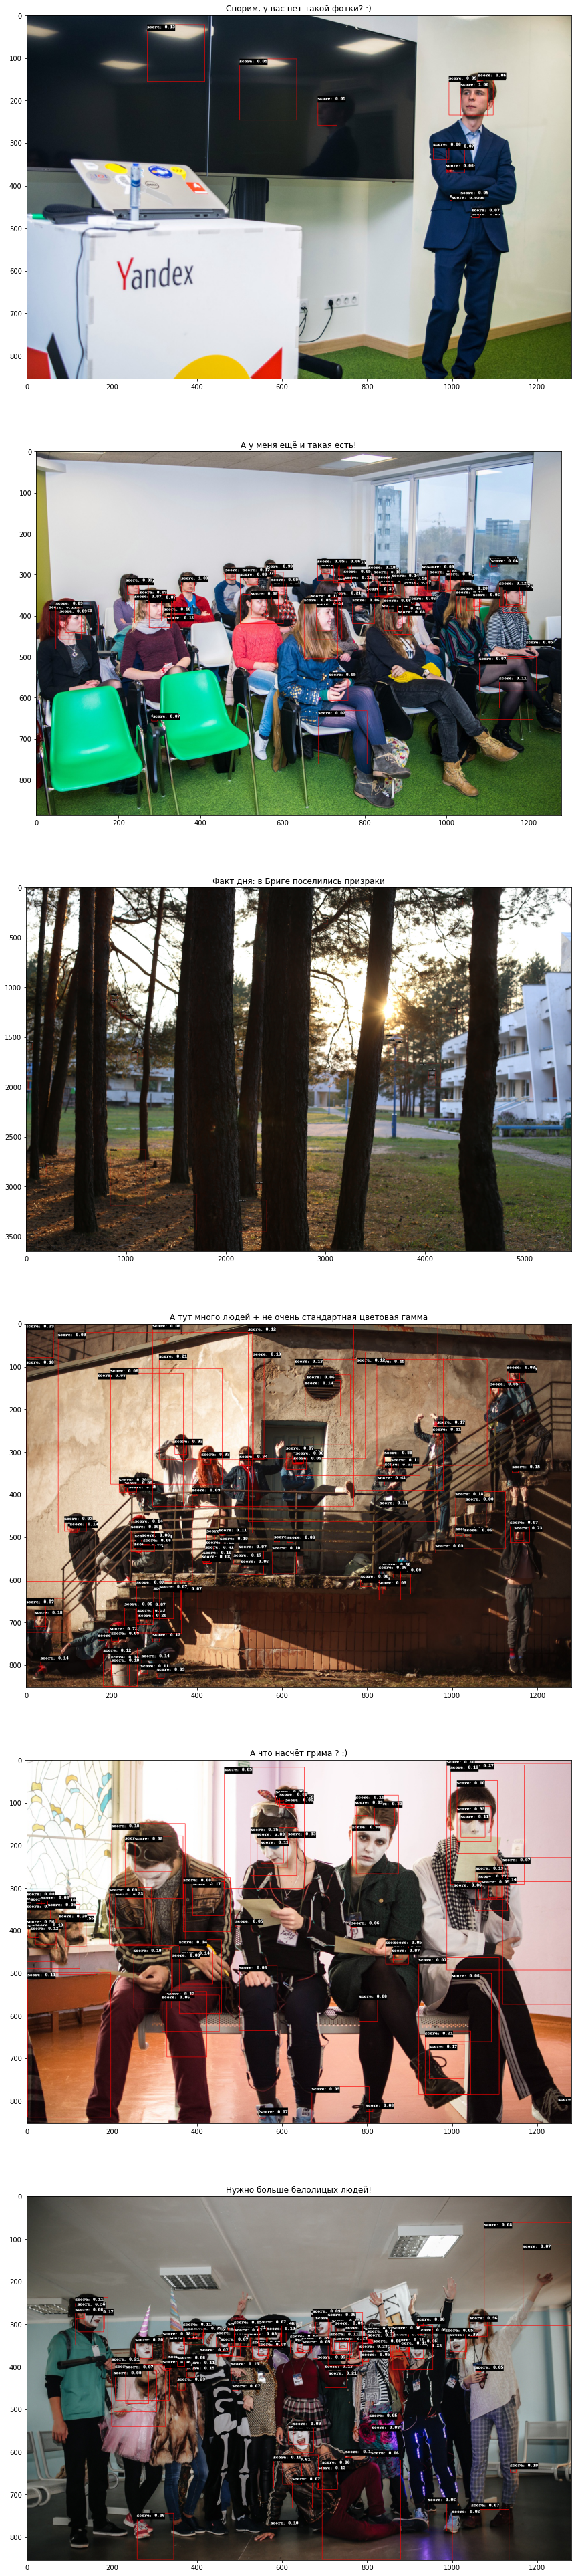

In [23]:
show_predictions(images, predictions, titles)

# **Планы на будущее**

*(я больше писала это для себя, чтобы ничего не забыть, но вдруг вам тоже будет интересно :) ).*

План А на ближайщее будущее:

1. Добавить тестовую выборку, чтобы можно было понять, насколько хорошо обучилась модель, нужно ли пытаться увеличить объём обучающей выборки и тд...

2. Провернуть то же самое для `RetinaNet` и метода Виолы-Джонса (реализация в cv)

3. Придумать, как это всё красиво структурировать, чтобы это было похоже на красивый проект, а не на рандомные куски кода.

План В (выполнять после плана А):

0. Обучить `Faster RCNN` и `RetinaNet` с 0. Можно взять готовые модели с параметром `pretrained=False` или посмотреть, какие там слои ( вроде как эта информация общедоступна) и прописать их явно. Может я не права, но оба способа выглядят, как одно и то же. 

1. (???) Построить свой метод Виолы-Джонса, используя классификатор из прошлой работы (Звучит как план энтузиаста, но наверное это реально сделать)

2. Сравнить результаты с нейронками из плана А.

3. Построить красивый визуал. Идея: взять пару картинок и прогнать каждое изображение через все сетки и вывести, чтобы посмотреть, как сетки справились с детекцией (таблицы с чиселками - это круто и очень по-научному, но как показал последний опыт, людям намного интереснее смотреть красивые картинки, чем таблички с кучей цифр:) ).

3. А вообще... Было бы прикольно сделать небольшую апишку, где пользователь мог бы сам загрузить какой-то свой снимок и получить результат. Такое было бы прикольно показать на защите :) 

4. Убедиться, что всё работает, как надо, и раснести весь код по файлам, а в ноутбука оставить только визуал + таблички и прочие интересности.

5. Наслаждаться проделанной работой :)

# Ещё планы, чтобы не забыть:

1. Поиграться с transform   

2. не загружать датасет в оперативку. Вместо этого один раз отдельно всё загрузить, поделить на train и test, и сохранить в таком виде.


In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Mar 25 01:11:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |   6106MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
titles = [
          'Спорим, у вас нет такой фотки? :)',
          'А у меня ещё и такая есть!',
          'Факт дня: в Бриге поселились призраки',
          'А тут много людей + не очень стандартная цветовая гамма',
          'А что насчёт грима ? :)',
          'Нужно больше белолицых людей!',
]

вот эту штуку я использовала 1 раз, а потом поняла, что мне не совсем удобно использовать такое (но не могу же я упустить возможность продемонстровать то, как я умею гуглить :) )

Но вообще, видимо, это можно уже удалять

In [ ]:
import requests

urls = [
        'https://raw.githubusercontent.com/rafaelpadilla/Object-Detection-Metrics/master/lib/BoundingBox.py',
        'https://raw.githubusercontent.com/rafaelpadilla/Object-Detection-Metrics/master/lib/BoundingBoxes.py',
        'https://raw.githubusercontent.com/rafaelpadilla/Object-Detection-Metrics/master/lib/Evaluator.py',
        'https://raw.githubusercontent.com/rafaelpadilla/Object-Detection-Metrics/master/lib/utils.py'
]


file_names = ['bounding_box.py', 'bounding_boxes.py', 'evaluator.py']
files = [open('face_detection/' + name, 'w') for name in file_names]
files.append(open('face_detection/utils.py', 'a'))

for url, f in zip(urls, files):
    resp = requests.get(url)
    f.write(resp.text)
    f.close()



In [25]:
from face_detection.bounding_box import BoundingBox
from face_detection.bounding_boxes import BoundingBoxes
from face_detection.utils import CoordinatesType, BBType, BBFormat


In [33]:
from data_loader import load_nn_model

WORK_PATH = '/content/drive/MyDrive/КУ Курсачи/Курсовая работа 2021/'


def add_boxes(test_dicts, model=load_model(trained=True)):

    dict_images = test_dicts[0]
    dict_frames = test_dicts[1]

    for key, rects in dict_frames.items():

        # let's add ground_truth_boxes first
        for rectangle in rects:
            x,y,w,h = rectangle
            gt_bounding_box = BoundingBox(imageName=key, classId='face', x=x, y=y,
                                w=w, h=h, typeCoordinates=CoordinatesType.Absolute,
                                bbType=BBType.GroundTruth, format=BBFormat.XYWH,
                                imgSize=dict_images[key].size)
            my_bounding_boxes.addBoundingBox(gt_bounding_box) 
            #print(rectangle)
            #print(gt_bounding_box.getAbsoluteBoundingBox())


        # now let's make predictions and add to our boxes all detected boxes
        image = test_transforms(dict_images[key])
        
        with torch.no_grad():
            prediction = model([image.to(device)])

        boxes = list(prediction[0]['boxes'].cpu().numpy())
        scores = list(prediction[0]['scores'].cpu().numpy())
        
        for i, box in enumerate(boxes):

            x, y, x2, y2 = box
            detected_bounding_box = BoundingBox(imageName=key, classId='face', classConfidence=scores[i], 
                                        x=x, y=y, w=x2, h=y2, typeCoordinates=CoordinatesType.Absolute,
                                        bbType=BBType.Detected, format=BBFormat.XYX2Y2, imgSize=dict_images[key].size)
            my_bounding_boxes.addBoundingBox(detected_bounding_box)
            #print(box)
            #print(detected_bounding_box.getAbsoluteBoundingBox())


In [34]:
my_bounding_boxes = BoundingBoxes()

add_boxes(test_dicts)
print(my_bounding_boxes.count())

82677


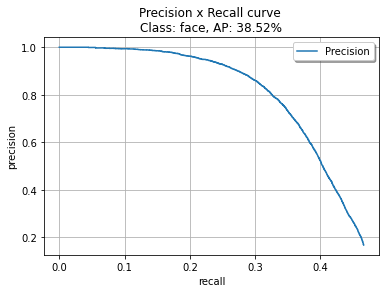

AP: 0.38518398891409716
total positives: 21954
total TP: 10233.0
total FP: 50490.0


In [35]:
import face_detection.evaluator as eval 

evaluator = eval.Evaluator()

results = evaluator.PlotPrecisionRecallCurve(
    boundingBoxes=my_bounding_boxes, showGraphic=True,
    showInterpolatedPrecision=False, showAP=True)

info = ['AP', 'total positives', 'total TP', 'total FP']


for params in info:
    print(params + f": {results[0][params]}")

# **Немного выводов**
### (и интересных фактов)

мне не нравится то, как Адам рисует рамочки. Их слишком много. Как-то SGD в визуализации лучше себя показал. 
Да и по метрике у него было 37%, что не сильно хуже.

Вывод: на данном этапе мне кажется, что достигнутая точность так себе, но добиться лучших результатов пока что не позволяют ресурсы :(

А ещё у меня график какой-то очень гладкий. В примере на гитхабе кривая была другой. Немного подозрительно, надо будет подумать над этим, мб я что-то не так сделала.